# Task 4 Transmembrane Potential Reconstruction

## PLAN

### 1.1 Task Description

Task 4 requires reconstructing the entire transmembrane potential curve for 75 points in the myocardium based on ECG data. This involves using machine learning to predict the activation function curve over time for each of these points.

### 1.2 Approach

1. **Data Utilization**:
   - Continue using the same dataset as in Task 3, which includes simulated ECG and activation maps.
   - This data mimics the biophysical phenomena occurring during the cardiac cycle, captured through transmembrane voltage recordings.

2. **Model Development**:
   - Develop or adapt neural networks that can interpret the spatial and temporal dynamics of the heart's electrical activity.
   - Expands this to model the continuous change in potential across different cardiac phases.

3. **Training and Evaluation**:
   - Train the neural network to learn from the simulated datasets where both the inputs (ECG data) and targets (transmembrane potential curves) are known.
   - Evaluate the model's accuracy in reconstructing these curves, ensuring it captures the detailed fluctuations in potential that correspond to different cardiac events.

### 1.3 Prepare


In [1]:
# Analysis
import numpy as np
import pandas as pd

import glob, re, os
from typing import List

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Data processing
from torch.utils.data import DataLoader, TensorDataset
from sklearn.utils import shuffle
from torch.optim.lr_scheduler import StepLR

# Save model
import pickle

# Ignore warning
import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_rows", 100)
plt.style.use('ggplot')

In [2]:
# Run the cardiac_ml_tools.py script
%run ./cardiac_challenge/notebooks/cardiac_ml_tools.py

In [3]:
# Load the dataset
data_dirs = []
regex = r'data_hearts_dd_0p2*'
DIR = './cardiac_challenge/intracardiac_dataset/' # path to the intracardiac_dataset

for x in os.listdir(DIR):
    if re.match(regex, x):
        data_dirs.append(DIR + x)
file_pairs = read_data_dirs(data_dirs)
print('Number of file pairs: {}'.format(len(file_pairs)))
# example of file pair
print("Example of file pair:")
print("{}\n{}".format(file_pairs[0][0], file_pairs[0][1]))

Number of file pairs: 16117
Example of file pair:
./cardiac_challenge/intracardiac_dataset/data_hearts_dd_0p2_geo_inn_act_3_bcl/pECGData_hearts_dd_0p2_geo_inn_act_3_bcl_bcl.1000.innerindex.0.volunteer.v13.npy
./cardiac_challenge/intracardiac_dataset/data_hearts_dd_0p2_geo_inn_act_3_bcl/VmData_hearts_dd_0p2_geo_inn_act_3_bcl_bcl.1000.innerindex.0.volunteer.v13.npy


## ANALYZE

Refer to Task 3. Task 4 step is very similar to Task 3, we use same split dataset and normalize data.

## CONSTRUCT

### 3.1 Data Processing

#### 3.1.1 Combine Dataset

The LSTM expects the input data to have the dimensions `[batch size, sequence length, features]` which is opposite to Task 3. In here, we have `[Sample size, 500, 12]`.

In [4]:
# If file active.npy and ecg.npy are already created, load them
if os.path.exists('./combine_dataset/ecg_data_t4.npy') and os.path.exists('./combine_dataset/vm_data.npy'):
    ECGData = np.load('./combine_dataset/ecg_data_t4.npy')
    VmData = np.load('./combine_dataset/vm_data.npy')

else:
    # file_pairs is a list where each element is a tuple containing the file paths for ECG data and activation time data
    num_samples = 16117  # Number of samples to process: Full dataset
    num_timesteps = 500  # Each ECG data has 500 timesteps
    num_leads = 12  # Standard ECG leads count after processing

    # Initialize arrays to store combined data
    ECGData = np.zeros((num_samples, num_timesteps, num_leads))  # 3D array for ECG data
    VmData = np.zeros((num_samples, num_timesteps, 75))  # Store 75 activation times per sample

    # Process each sample
    for i in range(num_samples):
        # Load ECG data
        pECGData = np.load(file_pairs[i][0])
        pECGData = get_standard_leads(pECGData)  # This should return data in the shape [num_timesteps, num_leads]
        ECGData[i, :, :] = pECGData

        # Load and process data
        pVmData = np.load(file_pairs[i][1])
        VmData[i, :, :] = pVmData

    # Create directory if it does not exist
    output_dir = './combine_dataset'
    os.makedirs(output_dir, exist_ok=True)

    # Save combined datasets to .npy format
    np.save(os.path.join(output_dir, 'ecg_data_t4.npy'), ECGData)
    np.save(os.path.join(output_dir, 'vm_data.npy'), VmData)

# Check the shape
print("ECGData shape: {}".format(ECGData.shape))
print("VmData shape: {}".format(VmData.shape))

ECGData shape: (16117, 500, 12)
VmData shape: (16117, 500, 75)


#### 3.1.2 Split Dataset

In [5]:
# Split Dataset

# Shuffle indices
indices = np.arange(ECGData.shape[0])
shuffled_indices = shuffle(indices, random_state=42)

# Define the split ratios
train_ratio = 0.6  # 60% training
val_ratio = 0.2  # 20% validation
test_ratio = 0.2  # 20% test

# Calculate the split points
train_split = int(len(shuffled_indices) * train_ratio)
val_split = int(len(shuffled_indices) * (train_ratio + val_ratio))

# Split indices into training, validation, and test sets
train_indices = shuffled_indices[:train_split]
val_indices = shuffled_indices[train_split:val_split]
test_indices = shuffled_indices[val_split:]

# Use indices to create training, validation, and test data
x_train = ECGData[train_indices]
y_train = VmData[train_indices]
x_val = ECGData[val_indices]
y_val = VmData[val_indices]
x_test = ECGData[test_indices]
y_test = VmData[test_indices]

# Print the shapes of the data
x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((9670, 500, 12),
 (9670, 500, 75),
 (3223, 500, 12),
 (3223, 500, 75),
 (3224, 500, 12),
 (3224, 500, 75))

#### 3.1.3 Normalize Data

In [6]:
# Convert numpy arrays to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
x_val_tensor = torch.tensor(x_val, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Calculate the min and max values and add to list
x_min_list = []
x_max_list = []
y_min_list = []
y_max_list = []

for i in range(x_train_tensor.shape[1]): # loop 12 leads
    min_value = x_train_tensor[:, i].min()
    max_value = x_train_tensor[:, i].max()
    x_min_list.append(min_value)
    x_max_list.append(max_value)

for i in range(y_train_tensor.shape[1]): # loop 75 activation times
    min_value = y_train_tensor[:, i].min()
    max_value = y_train_tensor[:, i].max()
    y_min_list.append(min_value)
    y_max_list.append(max_value)

print("Min values:", x_min_list, "\nMax values:", x_max_list)
print("Min values:", y_min_list, "\nMax values:", y_max_list)

Min values: [tensor(-0.0835), tensor(-0.1690), tensor(-0.2632), tensor(-0.3445), tensor(-0.4093), tensor(-0.4835), tensor(-0.5715), tensor(-0.6987), tensor(-1.0482), tensor(-1.5022), tensor(-1.8633), tensor(-2.1983), tensor(-2.6072), tensor(-2.9281), tensor(-3.2373), tensor(-3.4317), tensor(-3.6527), tensor(-3.9423), tensor(-4.0855), tensor(-4.1953), tensor(-4.1943), tensor(-4.2612), tensor(-4.2597), tensor(-4.2158), tensor(-4.1458), tensor(-4.1288), tensor(-4.1216), tensor(-4.1073), tensor(-4.0589), tensor(-3.9187), tensor(-3.7288), tensor(-3.5642), tensor(-3.6573), tensor(-3.8819), tensor(-4.0562), tensor(-4.2354), tensor(-4.2943), tensor(-4.4372), tensor(-4.4960), tensor(-4.5256), tensor(-4.5849), tensor(-4.5307), tensor(-4.3997), tensor(-4.2023), tensor(-4.2449), tensor(-4.2991), tensor(-4.4073), tensor(-4.5361), tensor(-4.6101), tensor(-4.5177), tensor(-4.5681), tensor(-4.6674), tensor(-4.7441), tensor(-4.8198), tensor(-4.9132), tensor(-4.9883), tensor(-5.0673), tensor(-5.1282), t

In [7]:
# Normalize the data
def normalize_x(data, min_val, max_val):
    # normalize_dataset = np.zeros(data.shape)
    for i in range(data.shape[1]):
        data[:, i] = np.divide(data[:, i], max_val[i])
    return data

# Normalize the datasets
x_train_normalized = normalize_x(x_train, np.min(x_train), x_max_list)
x_val_normalized = normalize_x(x_val, np.min(x_train), x_max_list)
x_test_normalized = normalize_x(x_test, np.min(x_train), x_max_list)

# You can print the shapes to verify the sizes are correct and the operations have been applied uniformly
print("Normalized training data shape:", x_train_normalized.shape)
print("Normalized validation data shape:", x_val_normalized.shape)
print("Normalized test data shape:", x_test_normalized.shape)


Normalized training data shape: (9670, 500, 12)
Normalized validation data shape: (3223, 500, 12)
Normalized test data shape: (3224, 500, 12)


In [8]:
# convery normalized to tensor
x_train_normalized_tensor = torch.tensor(x_train_normalized, dtype=torch.float32)
x_val_normalized_tensor = torch.tensor(x_val_normalized, dtype=torch.float32)
x_test_normalized_tensor = torch.tensor(x_test_normalized, dtype=torch.float32)

# Create a DataLoader for each dataset
batch_size = 64

train_data = TensorDataset(x_train_normalized_tensor, y_train_tensor)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

val_data = TensorDataset(x_val_normalized_tensor, y_val_tensor)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

test_data = TensorDataset(x_test_normalized_tensor, y_test_tensor)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

# Get the first batch of training data and shape
for i, (x_batch, y_batch) in enumerate(train_loader):
    print("x_batch shape:", x_batch.shape)
    print("y_batch shape:", y_batch.shape)
    break


x_batch shape: torch.Size([64, 500, 12])
y_batch shape: torch.Size([64, 500, 75])


### 3.2 Model

#### 3.2.1 Build Model

In [9]:
class EnhancedLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout_rate):
        super(EnhancedLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # LSTM layer with dropout
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout_rate)

        # Since you need to output predictions at each timestep for each feature,
        # the output layer should map the hidden state at each timestep to the output features.
        # We need to ensure the output is [batch_size, sequence_length, output_dim]
        self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Applying the linear layer to each time step
        out = self.linear(out)
        return out

# Model parameters
input_dim = 12  # Number of input features
hidden_dim = 64  # Number of features in hidden state
output_dim = 75  # Output features
num_layers = 2  # Number of recurrent layers
dropout_rate = 0.5  # Dropout rate

# Initialize the model
model = EnhancedLSTM(input_dim, hidden_dim, output_dim, num_layers, dropout_rate)

#### 3.2.2 Train Model

In [15]:
# Initialize the LSTM
# model = SimpleLSTM(input_dim, hidden_dim, output_dim, num_layers)

optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.L1Loss()  # MAE
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)  # Adjust learning rate every 10 epochs
num_epochs = 30
early_stopping_patience = 10
best_val_loss = float('inf')
counter = 0

train_losses, val_losses = [], []

# Training loop
for epoch in range(num_epochs):
    model.train()
    avg_train_loss = 0

    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(x_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        avg_train_loss += loss.item()

    avg_train_loss /= len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation phase
    model.eval()
    with torch.no_grad():
        val_output = model(x_val_normalized_tensor)
        val_loss = criterion(val_output, y_val_tensor)
        val_losses.append(val_loss.item())

    print(f'Epoch {epoch+1}, Loss: {avg_train_loss}, Val Loss: {val_loss.item()}')

    # Early stopping condition
    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        counter = 0  # Reset counter
    else:
        counter += 1
        if counter >= early_stopping_patience:
            print("Early stopping triggered")
            break

    scheduler.step()  # Adjust the learning rate based on the schedule

# Final loss outputs
print(f"Final Training Loss: {train_losses[-1]}")
print(f"Best Validation Loss: {best_val_loss}")

Epoch 1, Loss: 10.532074307140551, Val Loss: 11.208984375
Epoch 2, Loss: 9.52297788544705, Val Loss: 10.28419017791748
Epoch 3, Loss: 9.789832039883262, Val Loss: 10.103316307067871
Epoch 4, Loss: 9.231226212099978, Val Loss: 9.61879825592041
Epoch 5, Loss: 8.928797521089253, Val Loss: 9.756031036376953
Epoch 6, Loss: 8.78383648709247, Val Loss: 8.991538047790527
Epoch 7, Loss: 8.549925888839521, Val Loss: 8.760212898254395
Epoch 8, Loss: 8.386018492673573, Val Loss: 8.33105182647705
Epoch 9, Loss: 8.22919391017211, Val Loss: 8.185826301574707
Epoch 10, Loss: 8.064413020485325, Val Loss: 8.01857852935791
Epoch 11, Loss: 7.857595584894481, Val Loss: 8.077770233154297
Epoch 12, Loss: 7.816499496761121, Val Loss: 7.973419666290283
Epoch 13, Loss: 7.797847512521241, Val Loss: 7.974668502807617
Epoch 14, Loss: 7.7843501850178365, Val Loss: 7.980031490325928
Epoch 15, Loss: 7.758979427187066, Val Loss: 7.8944091796875
Epoch 16, Loss: 7.743813480201521, Val Loss: 7.914920806884766
Epoch 17, L

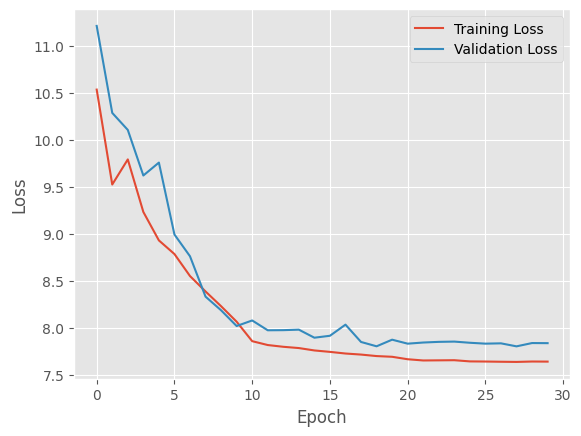

In [16]:
# Plot the training and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

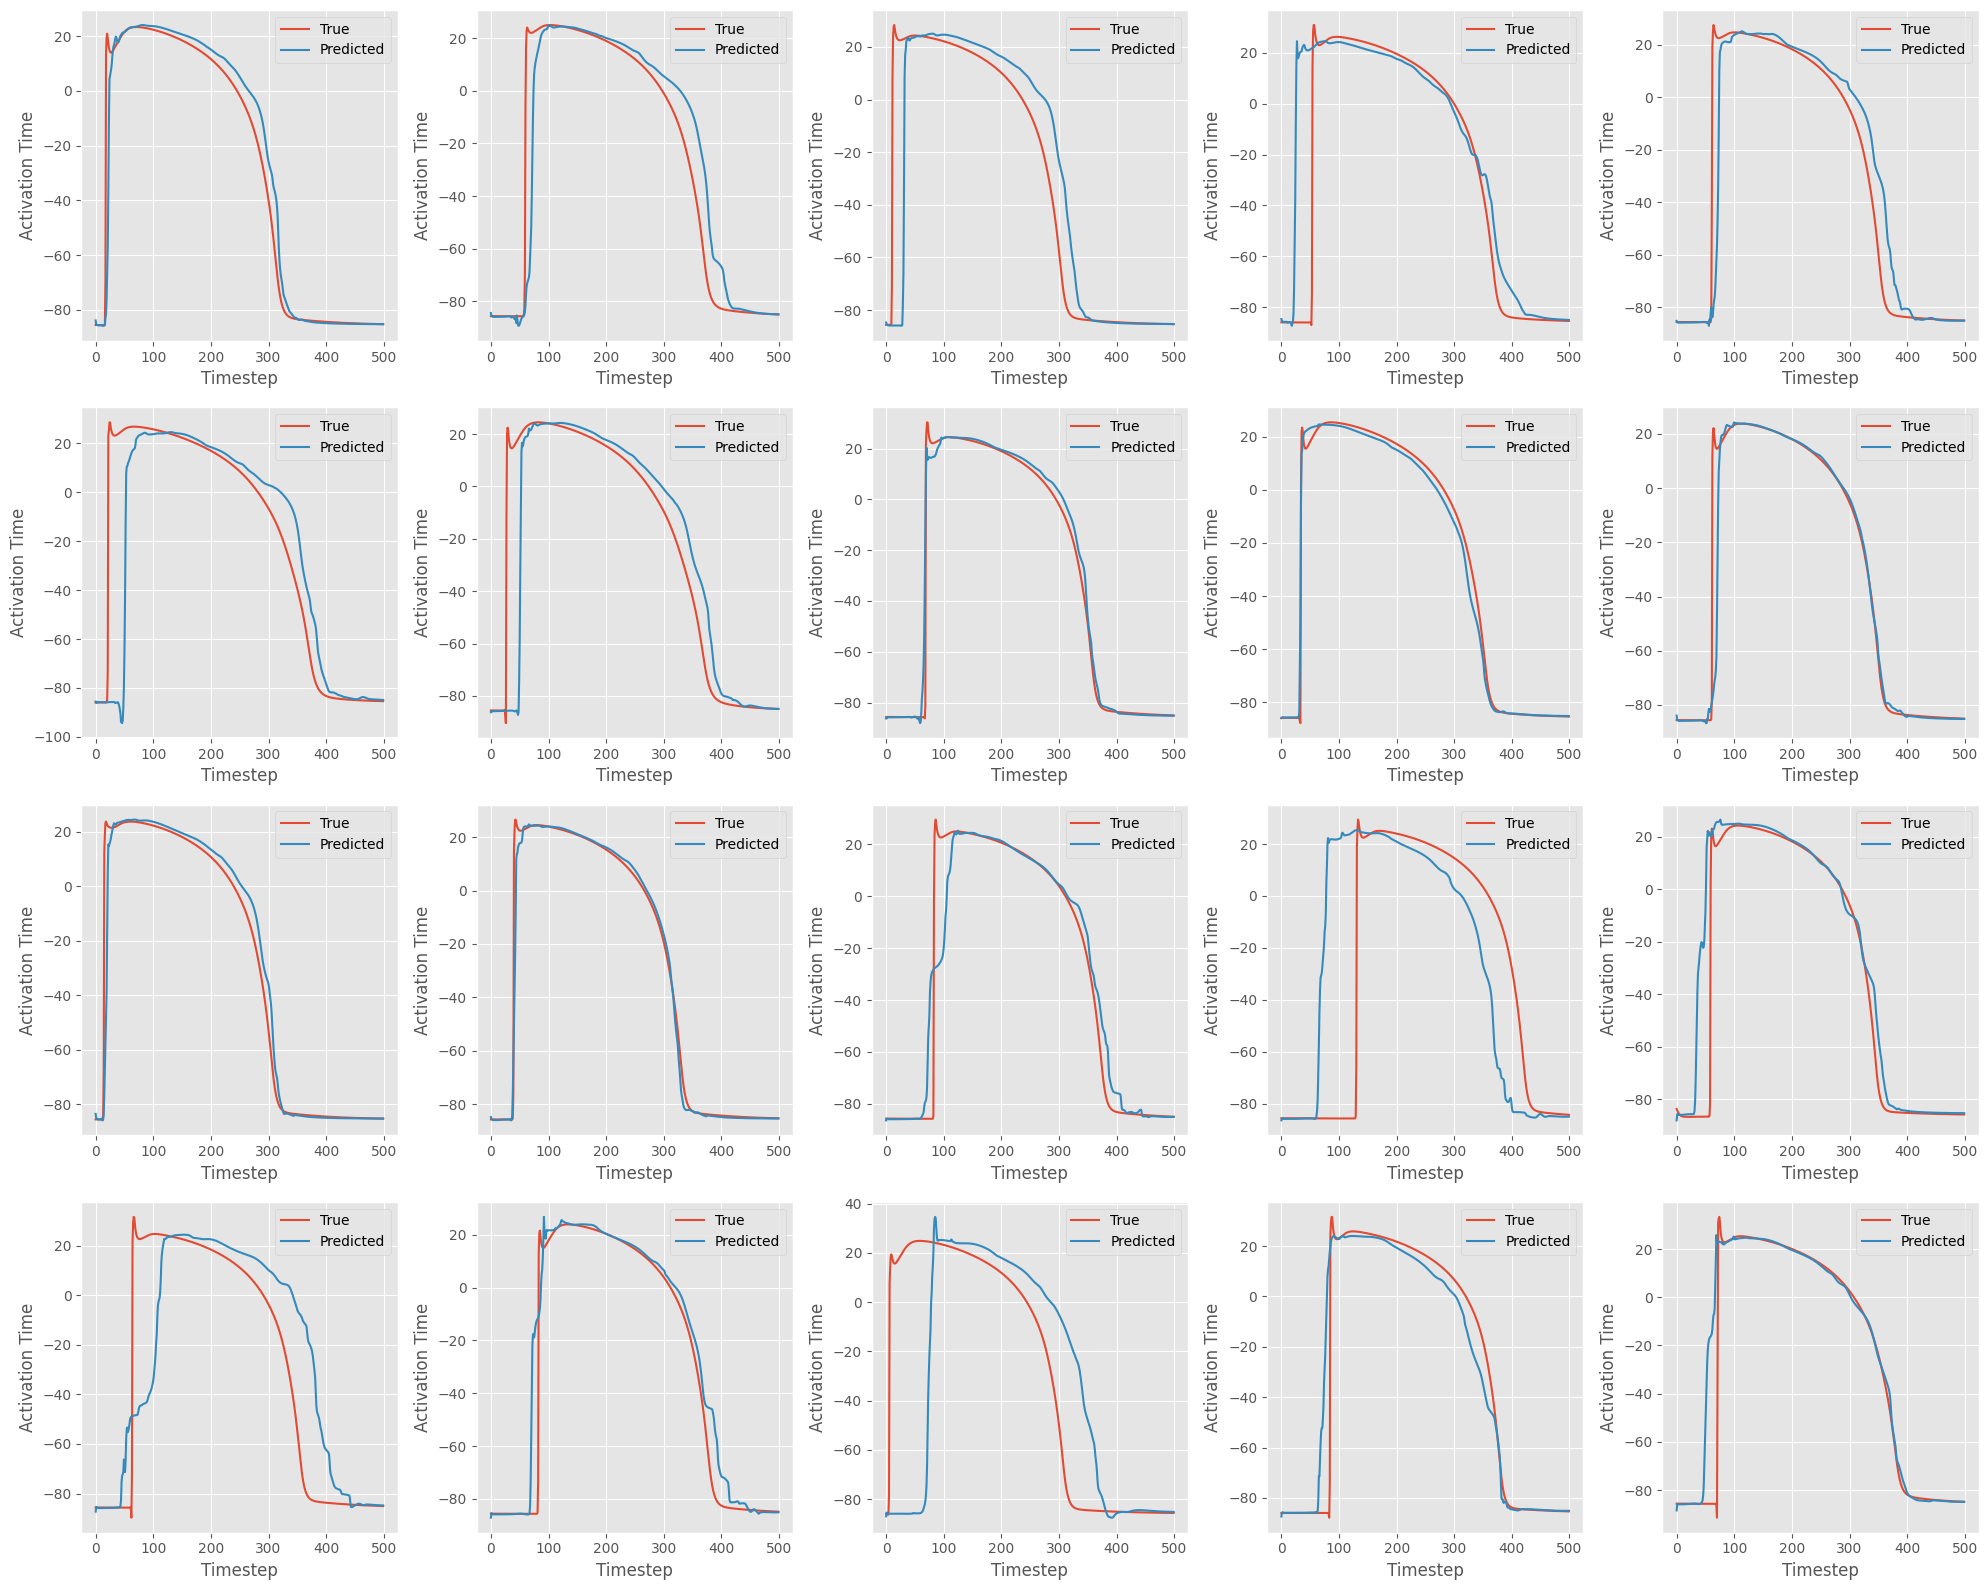

In [17]:
# Plot the sample individually: True vs Predicted

# Get the output of the model
model.eval()
with torch.no_grad():
    output = model(x_test_normalized_tensor)

fig, axes = plt.subplots(4, 5, figsize=(20, 16))

for i in range(20):
    row = i // 5
    col = i % 5
    ax = axes[row, col]
    ax.plot(y_test_tensor[i, :, i], label='True')
    ax.plot(output[i, :, i], label='Predicted')
    ax.set_xlabel('Timestep')
    ax.set_ylabel('Activation Time')
    ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

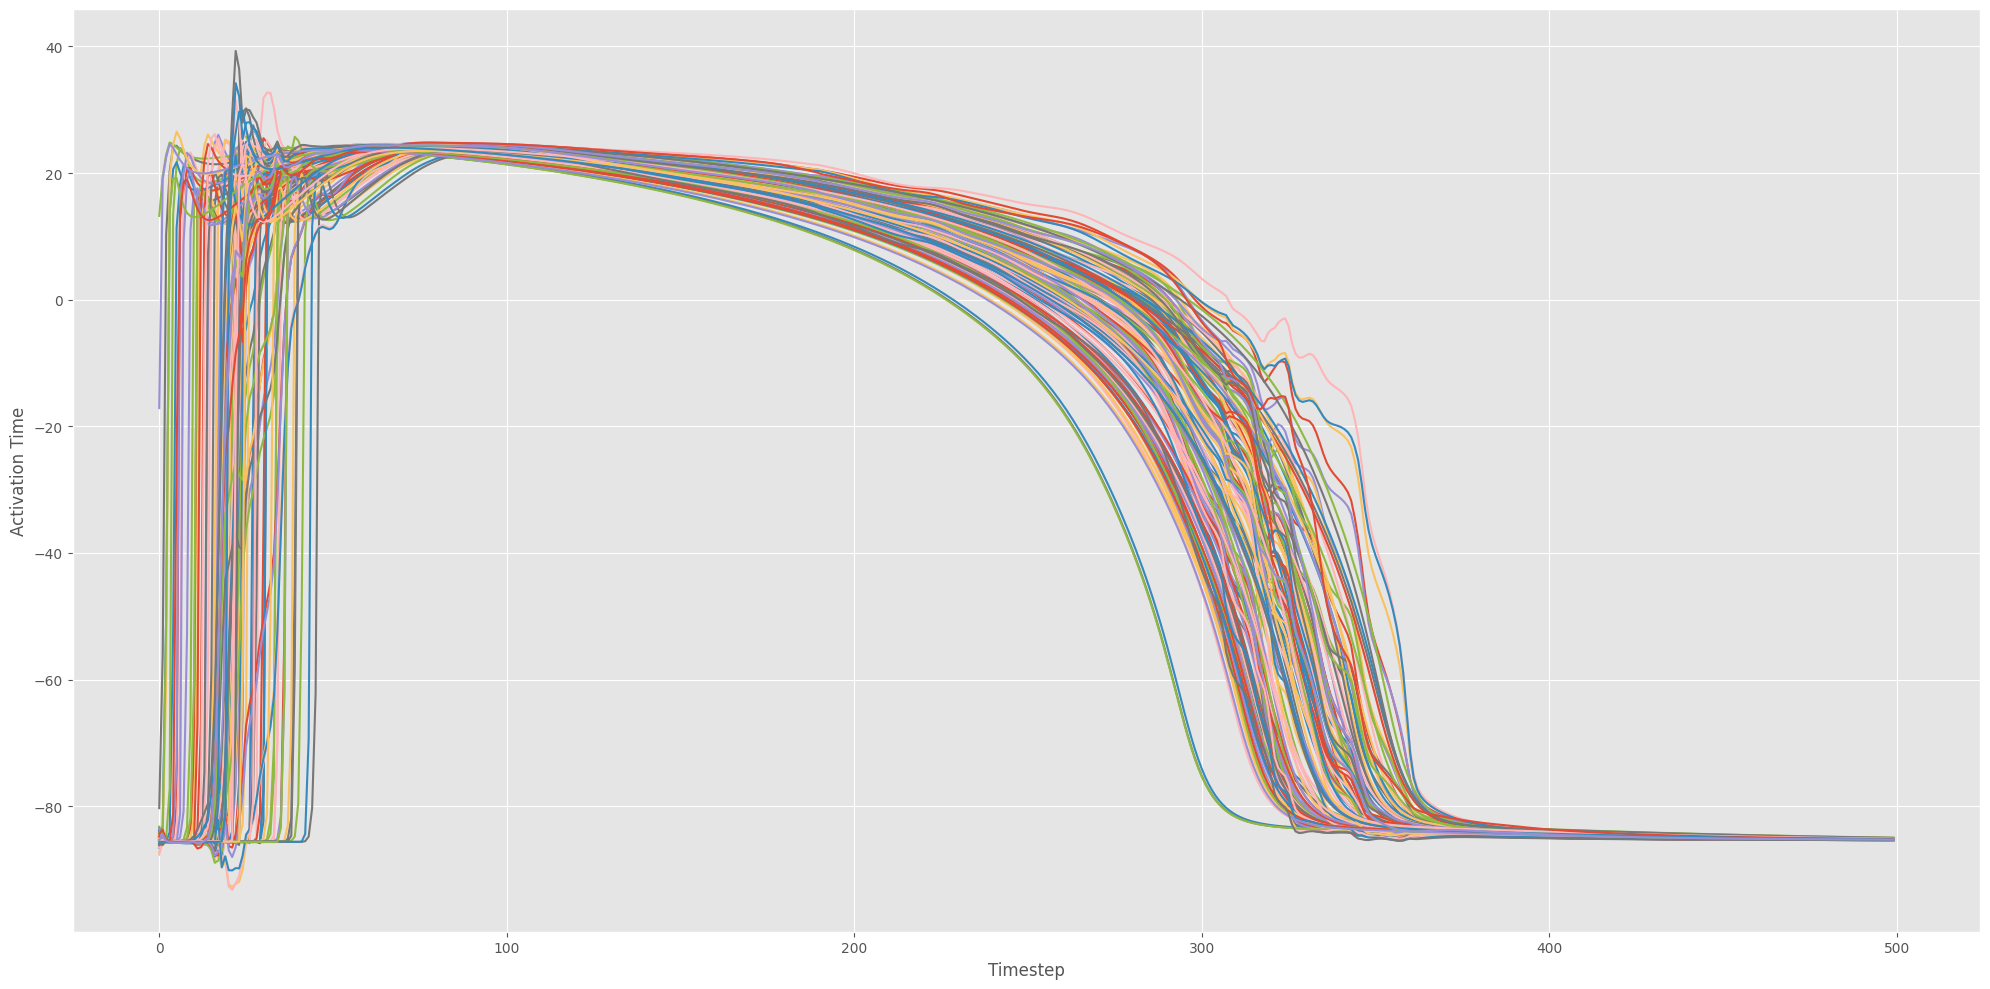

In [20]:
# Plot 75 curve into one plot
fig, ax = plt.subplots(figsize=(20, 10))

for i in range(75):
    ax.plot(y_test_tensor[0, :, i], label='True')
    ax.plot(output[0, :, i], label='Predicted')

ax.set_xlabel('Timestep')
ax.set_ylabel('Activation Time')

plt.tight_layout()
plt.show()

### 3.3 Evaluate the model

In [21]:
# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    test_output = model(x_test_normalized_tensor)
    test_loss = criterion(test_output, y_test_tensor)

print(f"Test Loss: {test_loss.item()}")

Test Loss: 7.837759971618652


## CONCLUSION

Due to limited time and computer resources, I will stop improving the model, and the final test loss is 7.8 ms. By viewing the individual sample graph, predicted VS true, which is okay. 